In [39]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch

from parallel_synapse_gradient import *
from utils_parallel_syn_gradient import *

In [40]:
def test_noisy_train_with_new_noisy_data(
    N=100, M=5, seed=0, P=100, n_repeat=20, noise_size=0.03, n_repeat_test=100
):
    allActv = []
    device = torch.device("cpu")

    path = ""
    folder = "./N_" + str(N) + "_noise"

    path += (
        "N_"
        + str(N)
        + "_M_"
        + str(M)
        + "_P_"
        + str(P)
        + "_seed_"
        + str(seed)
        + "_noise_size_"
        + str(noise_size)
        + "_noise_repeat_"
        + str(n_repeat)
    )
    data_ = load_model(folder + "/" + path + "_data")
    input_X, label = (
        data_[:, :-1].to(device),
        data_[:, -1].to(device),
    )

    model_params = {
        "N": N,  # input dimension
        "M": M,  # parallel synapse number
        "seed": seed,
        "device": device,
    }
    model = ParallelSyn(model_params)
    state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
    model.load_state_dict(state_dict, strict=False)

    inputX_noisy_test, label_noisy_test = add_noise(
        input_X, label, noise_size=noise_size, noise_repeat=n_repeat_test
    )
    # print test acc
    with torch.no_grad():
        actv = model(inputX_noisy_test)

    n_samples = label_noisy_test.shape[0]
    acc = (torch.sign(actv - model.theta) == label_noisy_test).sum() / n_samples
    return acc

In [41]:
acc_scaling = defaultdict(list)

for P in [400, 450, 500]:
    for seed in range(15):
        try:
            for count in range(5):
                acc = test_noisy_train_with_new_noisy_data(
                    N=100,
                    M=5,
                    seed=seed,
                    P=P,
                    n_repeat=20,
                    noise_size=0.03,
                    n_repeat_test=100,
                )
                acc_scaling[P].append(acc.item())
        except:
            continue


In [55]:
def plot_success_rate(
    acc_scaling,
    original_curve,
    N=100,
    M=5,
):
    P_list = np.array(list(acc_scaling.keys()))
    for threshold in [0.85, 0.9, 0.95, 0.99]:
        acc_mean = [np.mean(np.array(acc_scaling[P]) > threshold) for P in P_list]
        acc_std = [np.std(np.array(acc_scaling[P]) > threshold) for P in P_list]
        plt.errorbar(
            P_list / N,
            acc_mean,
            yerr=acc_std / np.sqrt(len(acc_scaling[P])),
            capsize=3,
            label="threshold={}".format(threshold),
        )
    # plt.plot(
    #     np.logspace(1, 3, 5),
    #     np.ones((5,)) * 2,
    #     "k--",
    #     linewidth=2.5,
    #     label="perceptron",
    # )
    PN_list = np.array(list(t[1] for t in original_curve))
    acc_mean = np.array(list(t[-1] for t in original_curve))
    plt.plot(PN_list, acc_mean, label="original", linewidth=2.5)
    plt.grid()
    plt.xlabel("P/N", fontsize=13)
    plt.ylabel("success rate", fontsize=13)
    plt.legend(loc="lower left")
    # plt.title("acc when tested with new noisy data (N={}, M={})".format(N, M))
    plt.show()


def plot_acc_scaling(
    acc_dict,
    original_curve,
    N=100,
    M=5,
):
    colors = ["tab:orange", "tab:green", "tab:red"]
    plt.figure(figsize=(3.5, 3.5), dpi=300)
    for i, (key, acc_scaling) in enumerate(acc_dict.items()):
        P_list = np.array(list(acc_scaling.keys()))
        acc_mean = [np.mean(np.array(acc_scaling[P])) for P in P_list]
        acc_std = [np.std(np.array(acc_scaling[P])) for P in P_list]

        plt.errorbar(
            P_list / N,
            acc_mean,
            yerr=acc_std / np.sqrt(len(acc_scaling[P])),
            capsize=3,
            label=key,
            color=colors[i],
        )
    # plt.plot(
    #     np.logspace(1, 3, 5),
    #     np.ones((5,)) * 2,
    #     "k--",
    #     linewidth=2.5,
    #     label="perceptron",
    # )
    plt.legend(loc="lower left")
    PN_list = np.array(list(t[1] for t in original_curve))
    acc_mean = np.array(list(t[-1] for t in original_curve))
    # plt.plot(PN_list, acc_mean, label="original", linewidth=2.5)
    plt.grid()
    plt.xlabel("P/N", fontsize=13)
    plt.ylabel("Accuracy", fontsize=13)
    plt.tight_layout()
    plt.savefig("acc_scaling_noisy_test.pdf")
    plt.show()

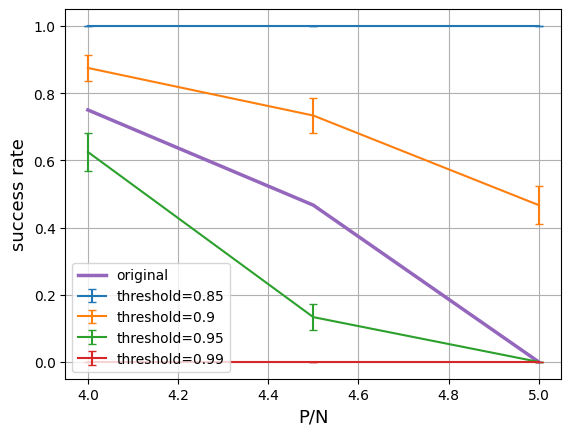

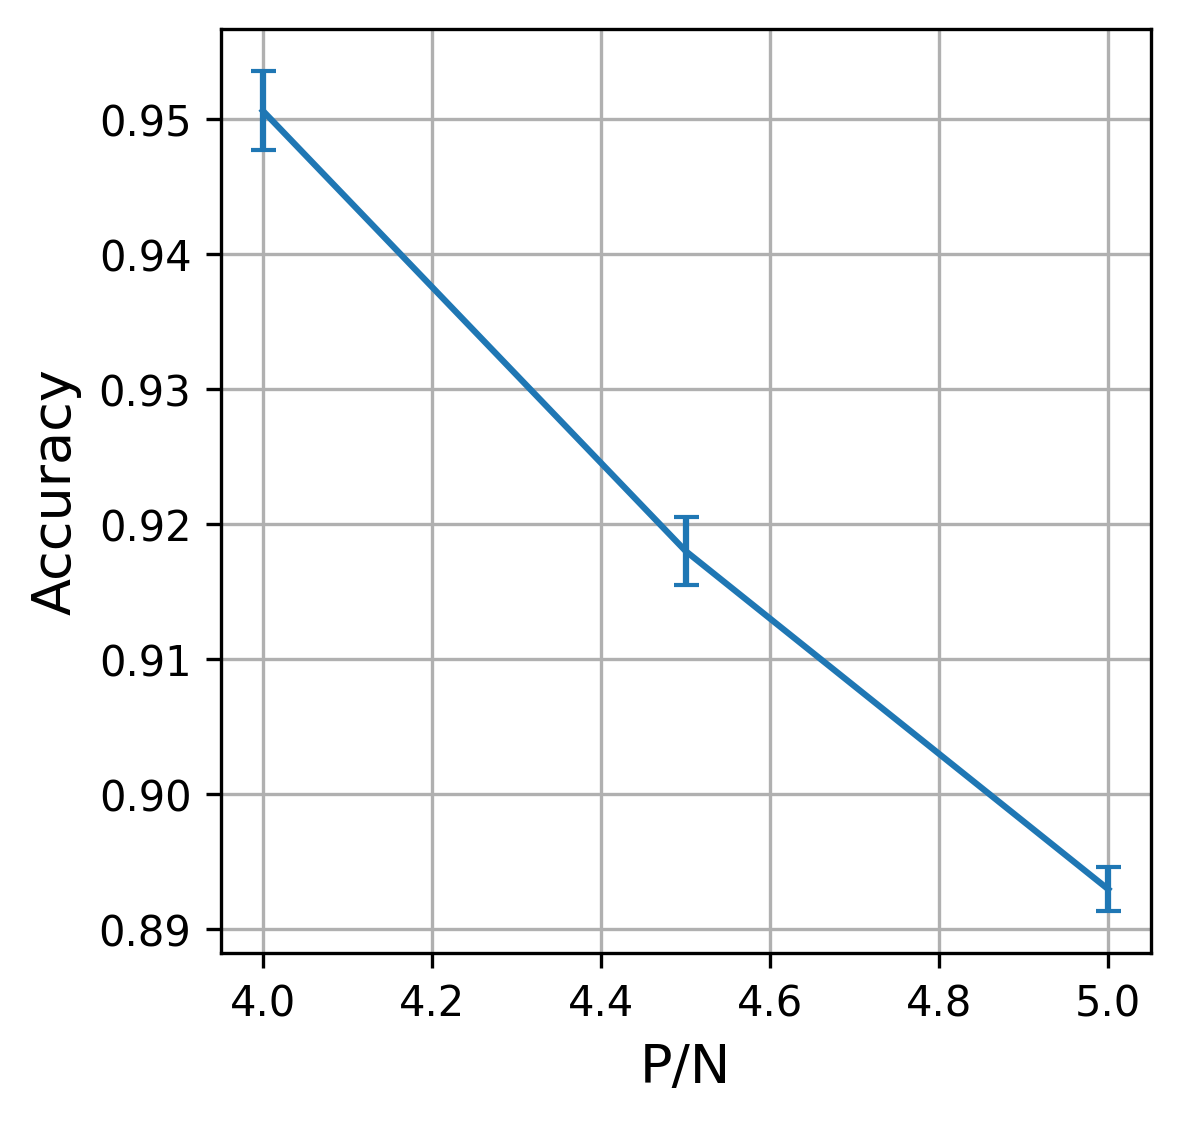

In [33]:
oringinal_curve = [
    (400, 4.0, 8, 0.75),
    # (440, 4.4, 8, 0.125),
    (450, 4.5, 15, 0.4666666666666667),
    (500, 5.0, 15, 0.0),
]
plot_success_rate(acc_scaling, oringinal_curve, N=100, M=5)
plot_acc_scaling(acc_scaling, oringinal_curve, N=100, M=5)

In [35]:
def test_accu_original_vs_noisy_train(
    N=100, M=5, seed=0, P=100, n_repeat=20, noise_size=0.03
):
    allActv = []
    device = torch.device("cpu")

    path = ""
    folder = "./N_" + str(N) + "_noise"

    path += (
        "N_"
        + str(N)
        + "_M_"
        + str(M)
        + "_P_"
        + str(P)
        + "_seed_"
        + str(seed)
        + "_noise_size_"
        + str(noise_size)
        + "_noise_repeat_"
        + str(n_repeat)
    )
    original_data_ = load_model(folder + "/" + path + "_data")
    original_input_X, original_label = (
        original_data_[:, :-1].to(device),
        original_data_[:, -1].to(device),
    )
    noisy_train_data_ = load_model(folder + "/" + path + "_noisy_train_data")
    noisy_train_input_X, noisy_train_label = (
        noisy_train_data_[:, :-1].to(device),
        noisy_train_data_[:, -1].to(device),
    )

    model_params = {
        "N": N,  # input dimension
        "M": M,  # parallel synapse number
        "seed": seed,
        "device": device,
    }
    model = ParallelSyn(model_params)
    state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
    model.load_state_dict(state_dict, strict=False)

    # print test acc
    with torch.no_grad():
        actv = model(original_input_X)

    n_samples = original_label.shape[0]

    acc_original = (torch.sign(actv - model.theta) == original_label).sum() / n_samples

    with torch.no_grad():
        actv = model(noisy_train_input_X)
    n_samples = noisy_train_label.shape[0]
    acc_noisy_train = (
        torch.sign(actv - model.theta) == noisy_train_label
    ).sum() / n_samples
    return acc_original, acc_noisy_train

In [36]:
acc_scaling_original = defaultdict(list)
acc_scaling_noisy_train = defaultdict(list)
for P in [400, 450, 500]:
    for seed in range(10):
        # try:
        for count in range(5):
            acc_original, acc_noisy_train = test_accu_original_vs_noisy_train(
                N=100,
                M=5,
                seed=seed,
                P=P,
                n_repeat=50,
                noise_size=0.03,
            )
            acc_scaling_original[P].append(acc_original.item())
            acc_scaling_noisy_train[P].append(acc_noisy_train.item())
        # except:
        #     continue

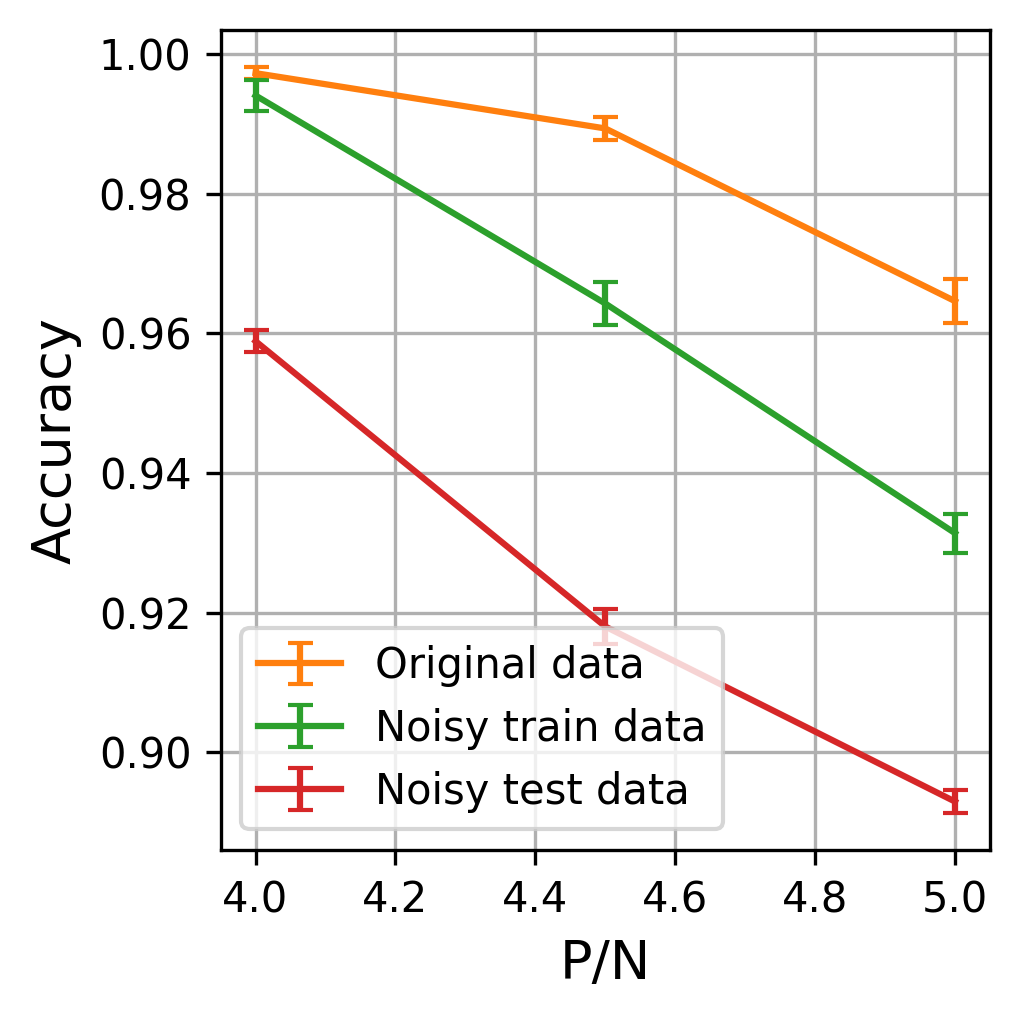

In [56]:
plot_acc_scaling(
    {
        "Original data": acc_scaling_original,
        "Noisy train data": acc_scaling_noisy_train,
        "Noisy test data": acc_scaling,
    },
    oringinal_curve,
    N=100,
    M=5,
)
